In [5]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile

In [3]:
sess = tf.Session() #初始化计算图
epochs = 20 #迭代次数
batch_size = 250 
max_sequence_length = 25 #每次输入的sentence的最大长度
rnn_size = 10 #RNN 的unit 个数
embedding_size = 50 #每一个词的embed 表达，embed的计算被引入到了神经网络之中
min_word_frequency = 10 #只有在字典中出现了10次以上的词才会被统计
learning_rate = 0.0005  #lr
dropout_keep_prob = tf.placeholder(tf.float32) #dropout有利于避免过拟合

In [6]:
zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
r=requests.get(zip_url)
z = ZipFile(io.BytesIO(r.content))
file = z.read('SMSSpamCollection')
text_data = file.decode()
text_data = text_data.encode('ascii',errors='ignore')
text_data = text_data.decode().split('\n')
text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [7]:
def clean_text(text_string):
 text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
 text_string = " ".join(text_string.split())
 text_string = text_string.lower()
 return(text_string)
text_data_train = [clean_text(x) for x in text_data_train]


In [8]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [9]:
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]



In [10]:
ix_cutoff = int(len(y_shuffled)*0.80) #表示 train：test=0.8:0.2
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)

In [11]:
x_data = tf.placeholder(tf.int32, [None, max_sequence_length]) #1*25的 输入
y_output = tf.placeholder(tf.int32, [None])
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size)
output, state = tf.nn.dynamic_rnn(cell=cell,inputs= embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)


Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(params=output, axis=int(output.get_shape()[0]) - 1)

TypeError: __int__ returned non-int (type NoneType)

In [14]:
weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1)) #全连接层
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

In [15]:
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out,labels=y_output)
loss = tf.reduce_mean(losses)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

In [16]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.initialize_all_variables()
sess.run(init)



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


D:\software\anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(100): #迭代次数
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    # 每一次迭代都需要打乱顺序
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1 #计算得出具体的批次数
    for i in range(num_batches):
        min_ix = i * batch_size  #这个批次训练x的最小index
        max_ix = np.min([len(x_train), ((i+1) * batch_size)]) #这个批次训练x的最大index
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        train_dict={
            x_data:x_train_batch,
            y_output:y_train_batch,
            dropout_keep_prob:0.5
        }
        sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))
#Epoch: 100, Test Loss: 0.35, Test Acc: 0.96

Epoch: 1, Test Loss: 0.45, Test Acc: 0.87
Epoch: 2, Test Loss: 0.45, Test Acc: 0.87
Epoch: 3, Test Loss: 0.45, Test Acc: 0.87
Epoch: 4, Test Loss: 0.44, Test Acc: 0.87
Epoch: 5, Test Loss: 0.44, Test Acc: 0.87
Epoch: 6, Test Loss: 0.44, Test Acc: 0.87
Epoch: 7, Test Loss: 0.44, Test Acc: 0.87
Epoch: 8, Test Loss: 0.44, Test Acc: 0.88
Epoch: 9, Test Loss: 0.44, Test Acc: 0.88
Epoch: 10, Test Loss: 0.44, Test Acc: 0.88
Epoch: 11, Test Loss: 0.44, Test Acc: 0.88
Epoch: 12, Test Loss: 0.44, Test Acc: 0.88
Epoch: 13, Test Loss: 0.44, Test Acc: 0.88
Epoch: 14, Test Loss: 0.44, Test Acc: 0.88
Epoch: 15, Test Loss: 0.43, Test Acc: 0.88
Epoch: 16, Test Loss: 0.43, Test Acc: 0.88
Epoch: 17, Test Loss: 0.43, Test Acc: 0.88
Epoch: 18, Test Loss: 0.43, Test Acc: 0.88
Epoch: 19, Test Loss: 0.43, Test Acc: 0.88
Epoch: 20, Test Loss: 0.43, Test Acc: 0.88
Epoch: 21, Test Loss: 0.42, Test Acc: 0.89
Epoch: 22, Test Loss: 0.4, Test Acc: 0.92
Epoch: 23, Test Loss: 0.38, Test Acc: 0.93
Epoch: 24, Test Loss:

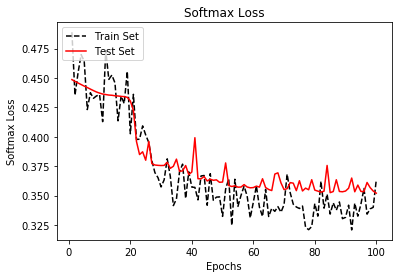

In [21]:
epoch_seq = np.arange(1, 100+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()